In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math

import matplotlib.pyplot as plt

import torch.distributions as dists
import torch.optim as optim

import copy

from collections import Counter

In [0]:
# Run on GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())

True


In [0]:
# Download and transform data
data_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root='./data', train=True, transform=data_transform, download=True)
test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=data_transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21243011.81it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 332455.95it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5274492.04it/s]                           
8192it [00:00, 128865.29it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
# Global Variables and Load Data
BATCH_SIZE = 100

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

NUM_TRAIN_POINTS = len(train_data)
NUM_TEST_POINTS = len(test_data)
NUM_TRAIN_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)
NUM_LABELS = 10
PI = 0.5

SIGMA1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA2 = torch.cuda.FloatTensor([math.exp(-6)]) 
IMG_HEIGHT, IMG_WIDTH = 28, 28
num_pixels = IMG_HEIGHT * IMG_WIDTH

NUM_SAMPLES = 20

In [0]:
# Variational Posterior
class ReparameterizedGaussian:
    def __init__(self, mus, rhos):
        self.mus = mus
        self.rhos = rhos
        self.shape = self.mus.size()
    
    def _get_sigmas(self):
        return torch.log(1 + torch.exp(self.rhos))
    def sample(self):        
        epsilon = dists.Normal(0, 1).sample(self.shape).to(DEVICE)
        
        sample = self.mus + self._get_sigmas() * epsilon
        return sample
    
    def get_variational_posterior(self, sample):
        pdf_likelihood = dists.Normal(self.mus, self._get_sigmas()).log_prob(sample)
        return pdf_likelihood.sum()
           

In [0]:
# Scale Mixture Prior
class ScaleMixturePrior:
    def __init__(self, sigma1, sigma2, pi):
        self.gaussian1 = dists.Normal(0, sigma1)
        self.gaussian2 = dists.Normal(0, sigma2)
        self.pi = pi
        
        if sigma1 < sigma2:
            print('Warning: sigma1 < sigma2 in the ScaleMixturePrior!')
            
    def get_prior(self, weights):
        likelihood1 = torch.exp(self.gaussian1.log_prob(weights))
        likelihood2 = torch.exp(self.gaussian2.log_prob(weights))
        
        prior_matrix = self.pi * likelihood1 + (1.0 - self.pi) * likelihood2
        return torch.log(prior_matrix).sum()

In [0]:
# Single Bayesian Layer
class BayesianLinearLayer(nn.Module):
    def __init__(self, in_size, out_size,
                mu_range=(-0.25, 0.25), rho_range=(-5, -4)):
        super().__init__()
        
        self.in_size = in_size
        self.out_size = out_size
        
        # Weights     
        self.weight_mus = nn.Parameter(torch.Tensor(out_size, in_size).uniform_(*mu_range))
        self.weight_rhos = nn.Parameter(torch.Tensor(out_size, in_size).uniform_(*rho_range))
        self.weight_prior = ScaleMixturePrior(SIGMA1, SIGMA2, PI)
        self.weight = ReparameterizedGaussian(self.weight_mus, self.weight_rhos)

        # Biases            
        self.bias_mus = nn.Parameter(torch.Tensor(out_size).uniform_(*mu_range))
        self.bias_rhos = nn.Parameter(torch.Tensor(out_size).uniform_(*rho_range))        
        self.bias_prior = ScaleMixturePrior(SIGMA1, SIGMA2, PI)        
        self.bias = ReparameterizedGaussian(self.bias_mus, self.bias_rhos) 
                
        self.variational_posterior = 0
        self.prior = 0
        
    def forward(self, x, sample=True):
        if sample or self.training:
            # Take weights/biases as samples from gaussians
            weights = self.weight.sample()
            biases = self.bias.sample()
    
            self.variational_posterior = \
            self.weight.get_variational_posterior(weights) +\
            self.bias.get_variational_posterior(biases)
            
            self.prior = \
            self.weight_prior.get_prior(weights) +\
            self.bias_prior.get_prior(biases)
            
        else:
            weights = self.weight.mus
            biases = self.bias.mus
            
            self.variational_posterior = 0
            self.prior = 0
        
        return F.linear(x, weights, bias=biases)        

In [0]:
# Multi-Layer Bayesian Neural Network
class BNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = BayesianLinearLayer(num_pixels, 400)
        self.layer2 = BayesianLinearLayer(400, 400)
        self.layer3 = BayesianLinearLayer(400, 10)
        
    def forward(self, x, sample=True):
        x = x.view(-1, num_pixels) # flatten
        x = F.relu(self.layer1(x, sample))
        x = F.relu(self.layer2(x, sample))
        x = F.relu(self.layer3(x, sample))
        
        x = F.log_softmax(x) 
        return x
        
    def get_total_variational_posterior(self):
        return self.layer1.variational_posterior +\
        self.layer2.variational_posterior +\
        self.layer3.variational_posterior
        
    def get_total_prior(self):
        return self.layer1.prior +\
        self.layer2.prior +\
        self.layer3.prior
    
    def get_loss(self, batch, target):

        # Tensors to store our monte carlo output
        outputs = torch.zeros(NUM_SAMPLES, BATCH_SIZE, NUM_LABELS).to(DEVICE)
        priors = torch.zeros(NUM_SAMPLES).to(DEVICE)
        variational_posteriors = torch.zeros(NUM_SAMPLES).to(DEVICE)
        
        # Monte Carlo sample the loss
        for i in range(NUM_SAMPLES):                      
            outputs[i] = self(batch, sample=True) # true for mc ensemble estimate
            variational_posteriors[i] = self.get_total_variational_posterior()
            priors[i] = self.get_total_prior()
                    
        variational_posterior = variational_posteriors.mean()        
        prior = priors.mean()
        error_signal = F.nll_loss(outputs.mean(0), target, size_average=False)      
        
        loss = (variational_posterior - prior) / BATCH_SIZE + error_signal
        
        return loss

In [0]:
random_net = BNN().to(DEVICE)
active_net = copy.deepcopy(random_net)

In [0]:
### Train the shared base

LIMITED_NUM_BATCHES = 150
BATCH_CEILING = 200
DIFFERENTIAL_TRAINING = 25

def dual_train(random_net, active_net, random_optimizer, active_optimizer, losses):
    random_net.train()
    active_net.train()
    
    for batch_idx, (batch, targets) in enumerate(train_loader):
        if batch_idx in range(LIMITED_NUM_BATCHES):
            batch, targets = batch.to(DEVICE), targets.to(DEVICE)
            
            random_net.zero_grad()
            active_net.zero_grad()
            
            random_loss = random_net.get_loss(batch, targets)
            active_loss = active_net.get_loss(batch, targets)
            
            losses.append(random_loss.item())
            
            random_loss.backward()
            active_loss.backward()
            
            random_optimizer.step()
            active_optimizer.step()
        
        
random_optimizer = optim.Adam(random_net.parameters())
active_optimizer = optim.Adam(active_net.parameters())
losses = []

for epoch in range(5): # defo increase
    print('Epoch {}... '.format(epoch), end='')
    dual_train(random_net, active_net, random_optimizer, active_optimizer, losses)
    print('Done')

print('\nDONE!')

Epoch 0... 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Done
Epoch 1... Done
Epoch 2... Done
Epoch 3... Done
Epoch 4... Done

DONE!


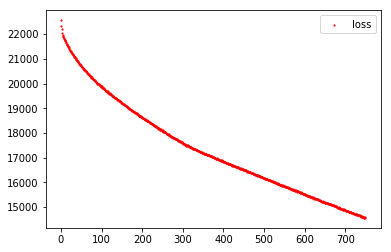

In [0]:
# Graph losses

plt.scatter(range(len(losses)), losses, c='r', s=5, label='loss', marker='.')
plt.legend()
plt.show()

In [0]:
### Train random net on additional random batches
def random_additional_train(random_net, random_optimizer, additional_random_losses):
    random_net.train()
    for batch_idx, (batch, targets) in enumerate(train_loader):
        
        # Train an additional 5 batches only
        if batch_idx in range(LIMITED_NUM_BATCHES, LIMITED_NUM_BATCHES + DIFFERENTIAL_TRAINING):
#             print('\nAdditional training on batch {}'.format(batch_idx))
        
            batch, targets = batch.to(DEVICE), targets.to(DEVICE)
            random_net.zero_grad()
            random_loss = random_net.get_loss(batch, targets)
            additional_random_losses.append(random_loss)
            random_loss.backward()
            random_optimizer.step()
         
        if batch_idx >= LIMITED_NUM_BATCHES + DIFFERENTIAL_TRAINING:
            break
                
additional_random_losses = []
print('Starting training')
for epoch in range(5):
    random_additional_train(random_net, random_optimizer, additional_random_losses)
    print('\nFinished epoch {}'.format(epoch))
print('\nDONE!')

Starting training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Finished epoch 0

Finished epoch 1

Finished epoch 2

Finished epoch 3

Finished epoch 4

DONE!


In [0]:
ACTIVE_POOL_SIZE = (BATCH_CEILING - LIMITED_NUM_BATCHES) * BATCH_SIZE
    
def get_prediction_distribution(active_net, point, mc_size=20):
    '''Return histogram of predictions from ensemble'''
    predictions_dist = Counter()
    for i in range(mc_size): 
        predictions_dist.update([torch.argmax(active_net(point, sample=True)).item()]) # pop item out       
    return predictions_dist


def get_uncertainty_scalar(active_net, point, mc_size=20):
    # Get predictions_cntr
    predictions_cntr = get_prediction_distribution(active_net, point)
    
    # Compute information entropy of prediction distribution. Say this our measure of uncertainty
    uncertainty_scalar = 0
    for num in predictions_cntr:       # zeros don't matter
        count = predictions_cntr[num]
        
        pX = count / mc_size
        uncertainty_scalar -= pX * math.log(pX)   # DTree information entropy

    return predictions_cntr, uncertainty_scalar      

def classify_active_pool(active_net, mc_size=20):
    '''Classifies uncertainty pool'''
    active_net.eval() 
  
      
    points = torch.zeros(ACTIVE_POOL_SIZE, 1, 28, 28).to(DEVICE) 
    labels = torch.zeros(ACTIVE_POOL_SIZE).to(DEVICE)
    uncertainty = torch.zeros(ACTIVE_POOL_SIZE).to(DEVICE)
    prediction_dist_list = []    
     
    with torch.no_grad(): # making sure not to accumulate any gradients
        point_num = -1 # point counter                
        
        for batch_idx, (batch, targets) in enumerate(train_loader):
            if batch_idx in range(LIMITED_NUM_BATCHES): # we already trained on this
                print('Skipping batch {}..'.format(batch_idx))
                continue                        
            else: # Unexplorerd territory. Classify and keep track.
                
                if batch_idx < BATCH_CEILING: # Let's break out early. Only active pool from first 100 batches                                        
                    print('Working on batch {}'.format(batch_idx))    
                    batch, targets = batch.to(DEVICE), targets.to(DEVICE)
                
                    for point, label in zip(batch, targets):
                        point_num += 1
                    
                        points[point_num] = point
                        labels[point_num] = label
                        prediction_cntr, uncertainty[point_num] = get_uncertainty_scalar(active_net, point, mc_size)
                    
                        prediction_dist_list.append(prediction_cntr)
                else:                    
                    print("\nBreak out of active pool classification before batch {}".format(batch_idx))
                    break
          
    return points, labels, uncertainty, prediction_dist_list                                        
    
    
points, labels, uncertainty, prediction_dist_list = classify_active_pool(active_net)
print('\nDONE!')


    

Skipping batch 0..
Skipping batch 1..
Skipping batch 2..
Skipping batch 3..
Skipping batch 4..
Skipping batch 5..
Skipping batch 6..
Skipping batch 7..
Skipping batch 8..
Skipping batch 9..
Skipping batch 10..
Skipping batch 11..
Skipping batch 12..
Skipping batch 13..
Skipping batch 14..
Skipping batch 15..
Skipping batch 16..
Skipping batch 17..
Skipping batch 18..
Skipping batch 19..
Skipping batch 20..
Skipping batch 21..
Skipping batch 22..
Skipping batch 23..
Skipping batch 24..
Skipping batch 25..
Skipping batch 26..
Skipping batch 27..
Skipping batch 28..
Skipping batch 29..
Skipping batch 30..
Skipping batch 31..
Skipping batch 32..
Skipping batch 33..
Skipping batch 34..
Skipping batch 35..
Skipping batch 36..
Skipping batch 37..
Skipping batch 38..
Skipping batch 39..
Skipping batch 40..
Skipping batch 41..
Skipping batch 42..
Skipping batch 43..
Skipping batch 44..
Skipping batch 45..
Skipping batch 46..
Skipping batch 47..
Skipping batch 48..
Skipping batch 49..
Skipping b

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Working on batch 151
Working on batch 152
Working on batch 153
Working on batch 154
Working on batch 155
Working on batch 156
Working on batch 157
Working on batch 158
Working on batch 159
Working on batch 160
Working on batch 161
Working on batch 162
Working on batch 163
Working on batch 164
Working on batch 165
Working on batch 166
Working on batch 167
Working on batch 168
Working on batch 169
Working on batch 170
Working on batch 171
Working on batch 172
Working on batch 173
Working on batch 174
Working on batch 175
Working on batch 176
Working on batch 177
Working on batch 178
Working on batch 179
Working on batch 180
Working on batch 181
Working on batch 182
Working on batch 183
Working on batch 184
Working on batch 185
Working on batch 186
Working on batch 187
Working on batch 188
Working on batch 189
Working on batch 190
Working on batch 191
Working on batch 192
Working on batch 193
Working on batch 194
Working on batch 195
Working on batch 196
Working on batch 197
Working on ba

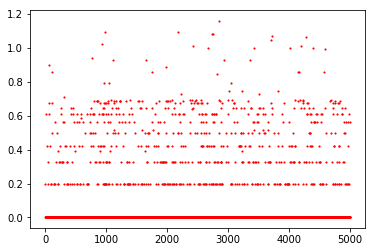

In [0]:

plt.scatter(range(len(uncertainty)), uncertainty.cpu(), c='r', s=5, label='loss', marker='.')


Text(0, 0.5, 'Information Entropy of Predictive Ensemble')

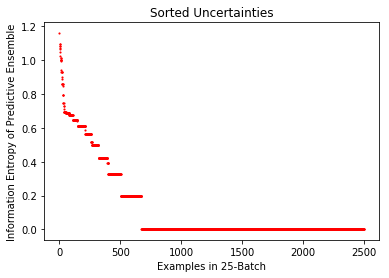

In [0]:

# Zip and sort examples by uncertainty
big_zip = zip(points, labels, uncertainty, prediction_dist_list)
sorted_big_zip = reversed(sorted(big_zip, key=lambda x: x[2])) # might need a .item() here

# Get 5 batches worth of the most uncertain examples
zipped_active_batch = list(sorted_big_zip)[:(DIFFERENTIAL_TRAINING*BATCH_SIZE)] 

# De-zip
sorted_points, sorted_labels, sorted_uncertainties, sorted_pdl = zip(*zipped_active_batch)

# Plot our sorted uncertainties
sorted_uncertainties_plot = [x.item() for x in sorted_uncertainties]
plt.scatter(range(len(sorted_uncertainties_plot)), sorted_uncertainties_plot, c='r', s=5, label='loss', marker='.')
plt.title('Sorted Uncertainties')
plt.xlabel('Examples in 25-Batch')
plt.ylabel('Information Entropy of Predictive Ensemble')



In [0]:
### Turn the list of tensors into batches

# Stack into one big tensor
s_points = torch.stack(sorted_points)
s_labels = torch.stack(sorted_labels)

# Permute
rand_indx = torch.randperm(DIFFERENTIAL_TRAINING*BATCH_SIZE)

shuffled_points = s_points[rand_indx]
shuffled_labels = s_labels[rand_indx]

active_batches = torch.chunk(shuffled_points, DIFFERENTIAL_TRAINING, dim=0)
active_labels = torch.chunk(shuffled_labels, DIFFERENTIAL_TRAINING, dim=0)


torch.Size([2500, 1, 28, 28])
torch.Size([2500, 1, 28, 28])
torch.Size([100, 1, 28, 28])
25
torch.Size([2500])
torch.Size([100])
5000


In [0]:

### Train on the most uncertain examples (shuffled)
def active_additional_train(active_net, active_optimizer, additional_active_losses,\
                            active_batches, active_labels):
    active_net.train()
    for batch_idx, (batch, targets) in enumerate(zip(active_batches, active_labels)):
#         print('\nAdditional active_net training, batch {}'.format(batch_idx))
                
        batch, targets = batch.to(DEVICE), targets.to(DEVICE)

        targets = targets.to(dtype=torch.long) 
        
        active_net.zero_grad()
        active_loss = active_net.get_loss(batch, targets)
        additional_active_losses.append(active_loss)
        active_loss.backward()
        active_optimizer.step()
       

# pass in active_batches, active_labels
additional_active_losses = []
for epoch in range(5):
    active_additional_train(active_net, active_optimizer, additional_active_losses,\
                           active_batches, active_labels)
    print('Finished epoch {}!'.format(epoch))

print('\nDONE!')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Finished epoch 0!
Finished epoch 1!
Finished epoch 2!
Finished epoch 3!
Finished epoch 4!

DONE!


In [0]:
### Evaluation on test set.

def mc_classify(net, point, mc_size, dist=False):
    '''samples mc_size times and returns max of average prediction'''
    # TODO: Is this what mc_classify should do?
    
    predictions = torch.zeros(mc_size, NUM_LABELS)
    
    for i in range(mc_size):
        predictions[i] = net(point, sample=True)

    pred_distribution = predictions.mean(0) # is this the right axis?
    
    if dist:
        return pred_distribution
    return torch.argmax(pred_distribution)

    
def ensemble_classify(net, mc_size=10, override_num_test_points=float('inf'), net_name='net'):
    '''Returns labels, predictions'''    
    
    NUM_TEST_POINTS = min(len(test_loader)*BATCH_SIZE, override_num_test_points)
#     print('check: {}'.format(str(len(test_loader)*BATCH_SIZE)))
  
    net.eval()
    
    predictions = torch.zeros(NUM_TEST_POINTS).to(DEVICE)
    labels = torch.zeros(NUM_TEST_POINTS).to(DEVICE)
    
    with torch.no_grad(): # why is this necessary
        point_num = -1
        for batch_idx, (current_batch, targets) in enumerate(test_loader):
            if point_num >= NUM_TEST_POINTS-1: # let's just classify the first batch for now
                print('Reached NUM_TEST_POINTS. Breaking out at point {}\n\n'.format(point_num))
                break
                    
            current_batch = current_batch.to(DEVICE)
            targets = targets.to(DEVICE)
            for point, label in zip(current_batch, targets):
                point_num += 1
                
                predictions[point_num] = mc_classify(net, point, mc_size)
                labels[point_num] = label
                
                if point_num % 100 == 0:
                    print('{} classifying point {}'.format(net_name, point_num))
                    
    return labels, predictions

In [0]:
random_labels, random_predictions = ensemble_classify(random_net, override_num_test_points=2500,\
                                                     net_name='random_net')
active_labels, active_predictions = ensemble_classify(active_net, override_num_test_points=2500,\
                                                     net_name='active_net')
print('\nDONE!')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


random_net classifying point 0
random_net classifying point 100
random_net classifying point 200
random_net classifying point 300
random_net classifying point 400
random_net classifying point 500
random_net classifying point 600
random_net classifying point 700
random_net classifying point 800
random_net classifying point 900
random_net classifying point 1000
random_net classifying point 1100
random_net classifying point 1200
random_net classifying point 1300
random_net classifying point 1400
random_net classifying point 1500
random_net classifying point 1600
random_net classifying point 1700
random_net classifying point 1800
random_net classifying point 1900
random_net classifying point 2000
random_net classifying point 2100
random_net classifying point 2200
random_net classifying point 2300
random_net classifying point 2400
Reached NUM_TEST_POINTS. Breaking out at point 2499


active_net classifying point 0
active_net classifying point 100
active_net classifying point 200
active_net 

In [0]:
 
def get_accuracies(labels, predictions, net_name='net'):
    '''Get accuracy by label'''
    print('PRINTING ACCURACIES FOR {}'.format(net_name))
    label_pred = {}

    # print(list(zip(labels, predictions)))
    for label, pred in zip(labels, predictions):
        if str(int(label.item())) not in label_pred:
            label_pred[str(int(label.item()))] = []
        label_pred[str(int(label.item()))].append(str(int(pred.item()))) # do we need a .item() here
    

    sorted_accuracies = []
    for label in sorted(label_pred):   
        num_correct = len([x for x in label_pred[label] if x == label])
        print('Label {}: {} correct out of {}'.format(label, num_correct, len(label_pred[label])))       
        sorted_accuracies.append(num_correct / len(label_pred[label]))

    return label_pred, sorted_accuracies
        
random_lp, random_accuracies = get_accuracies(random_labels, random_predictions, net_name='random_net')
print('\n')
active_lp, active_accuracies = get_accuracies(active_labels, active_predictions, net_name='active_net')

PRINTING ACCURACIES FOR random_net
Label 0: 214 correct out of 219
Label 1: 282 correct out of 287
Label 2: 263 correct out of 276
Label 3: 244 correct out of 254
Label 4: 259 correct out of 275
Label 5: 203 correct out of 221
Label 6: 217 correct out of 225
Label 7: 242 correct out of 257
Label 8: 220 correct out of 242
Label 9: 226 correct out of 244


PRINTING ACCURACIES FOR active_net
Label 0: 209 correct out of 219
Label 1: 279 correct out of 287
Label 2: 262 correct out of 276
Label 3: 237 correct out of 254
Label 4: 246 correct out of 275
Label 5: 199 correct out of 221
Label 6: 214 correct out of 225
Label 7: 236 correct out of 257
Label 8: 224 correct out of 242
Label 9: 236 correct out of 244


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '6', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '7', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'

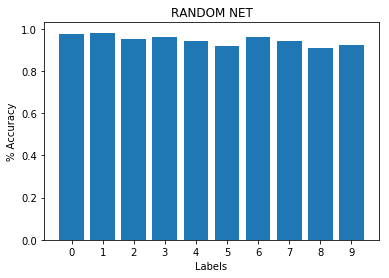

In [0]:
plt.bar(sorted(list(random_lp.keys())), random_accuracies)

plt.title('RANDOM NET')
plt.xlabel('Labels')
plt.ylabel('% Accuracy')
plt.show()


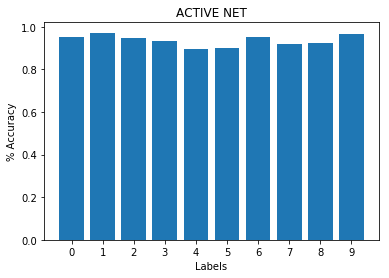

In [0]:
plt.bar(sorted(list(active_lp.keys())), active_accuracies)

plt.title('ACTIVE NET')
plt.xlabel('Labels')
plt.ylabel('% Accuracy')
plt.show()